In [11]:
from __future__ import division, print_function
import os

Train_model = False

#%% load libraries

import AE_fun as AE
import numpy as np
import matplotlib.pyplot as plt
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib','nbagg')
get_ipython().run_line_magic('matplotlib','inline')
import tensorflow as tf
import csv
from sklearn.metrics import confusion_matrix
import itertools
from PIL import Image
import AE_fun as AE
import numpy as np
from tools import sigmoid, softmax, plot_confusion_matrix
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

In [3]:

data = np.load('data/mnist.npz')
classes = list(range(10))
classes_plot = classes
included_classes = [0,1,2,3,4,5,6,7,8,9]
idxs_train = []
idxs_valid = []
idxs_test = []
num_classes = 0
for c in included_classes:
    if c in classes:
        num_classes += 1
        idxs_train += np.where(data['y_train'] == c)[0].tolist()
        idxs_valid += np.where(data['y_valid'] == c)[0].tolist()
        idxs_test += np.where(data['y_test'] == c)[0].tolist()

print("Number of classes included:", num_classes)
x_train = data['X_train'].astype('float32')
targets_train = data['y_train'].astype('int32')

x_train, targets_train = shuffle(x_train, targets_train, random_state=1234)


x_valid = data['X_valid'].astype('float32')
targets_valid = data['y_valid'].astype('int32')

x_test = data['X_test'].astype('float32')
targets_test = data['y_test'].astype('int32')

print("training set dim(%i, %i)." % x_train.shape)
print("validation set dim(%i, %i)." % x_valid.shape)
print("test set dim(%i, %i)." % x_test.shape)

Number of classes included: 10
training set dim(50000, 784).
validation set dim(10000, 784).
test set dim(10000, 784).


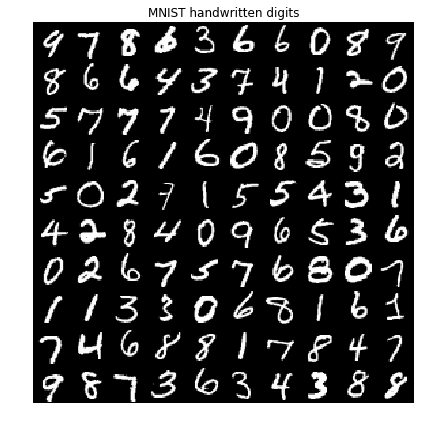

In [4]:
#%%plot a few MNIST examples
if True:
    idx = 0
    canvas = np.zeros((28*10, 10*28))
    for i in range(10):
        for j in range(10):
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
            idx += 1
    plt.figure(figsize=(7, 7))
    plt.axis('off')
    plt.imshow(canvas, cmap='gray')
    plt.title('MNIST handwritten digits')

In [5]:
#%% Train first Auto Encoder
if Train_model:
    out = AE.Sparse_Non_Neg_AE(x_train = x_train, x_valid = x_valid,use_LS = True,num_epochs = 1000
                               ,train_thresh = 10
                               , n_weight_burn = 5
                               , extra_epoch = 300
                               ,weights_burn_in = np.linspace(0.1,1,num = 10)
                               )
    
    sess,train_loss,train_loss_pure,valid_loss = tuple(out)
    params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    param_1 = tuple(sess.run(params))
    saver = tf.train.Saver()
    saver.save(sess, 'models/MNIST_layer_1.ckpt')
    tf.reset_default_graph()
else:
    saver = tf.train.import_meta_graph("models/MNIST_layer_1.ckpt.meta")
    
    with tf.Session() as sess:
        saver.restore(sess,"models/MNIST_layer_1.ckpt")
        params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        param_1 = tuple(sess.run(params))
    tf.reset_default_graph()

#%% Evaluate first Auto Encoder
enc_train = sigmoid(np.matmul(a=x_train,b = param_1[0]) + param_1[1])
enc_valid = sigmoid(np.matmul(a=x_valid,b = param_1[0]) + param_1[1])
enc_test = sigmoid(np.matmul(a=x_test,b = param_1[0]) + param_1[1])
#%%Train second Auto Encoder
tf.reset_default_graph()
if Train_model:
    hiddenSizeL2 = 20;
    out2 = AE.Sparse_Non_Neg_AE(x_train = enc_train, x_valid = enc_valid,use_LS = True,
                                num_epochs = 2000,num_hidden = hiddenSizeL2
                                ,batch_size = 1000
                                ,p_target = 0.05
                                ,train_thresh = 2
                                ,epoch_burn_in = 30
                                ,extra_epoch = 2000
                                ,n_weight_burn = 30
                                )
    
    sess2,train_loss2,train_loss_pure2,valid_loss2,train_reg2,train_sparse2 = tuple(out2)
    params2 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    param_2 = tuple(sess2.run(params2))
    saver = tf.train.Saver()
    saver.save(sess2, 'models/MNIST_layer_2.ckpt')
    tf.reset_default_graph()
else:
    tf.reset_default_graph()
    saver = tf.train.import_meta_graph("models/MNIST_layer_2.ckpt.meta")
    with tf.Session() as sess2:
        saver.restore(sess2,"models/MNIST_layer_2.ckpt")
        params2 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        param_2 = tuple(sess2.run(params2))
    tf.reset_default_graph()
        
#%% Evaluate second Auto Encoder
enc_2_train = sigmoid(np.matmul(a=enc_train,b = param_2[0]) + param_2[1])
enc_2_valid = sigmoid(np.matmul(a=enc_valid,b = param_2[0]) + param_2[1])
enc_2_test = sigmoid(np.matmul(a=enc_test,b = param_2[0]) + param_2[1])

INFO:tensorflow:Restoring parameters from models/MNIST_layer_1.ckpt
INFO:tensorflow:Restoring parameters from models/MNIST_layer_2.ckpt


In [6]:
y_train = np.eye(10)[targets_train]
y_valid = np.eye(10)[targets_valid]
y_test = np.eye(10)[targets_test]
alpha = 0.003


#%%Train softmax layer
tf.reset_default_graph()
if Train_model:
    out3 = AE.Non_neg_softmax(x_train = enc_2_train,y_train = y_train, x_valid = enc_2_valid,y_valid = y_valid,
                                num_epochs = 400
                                ,batch_size = 300
                                )
    
    sess3,train_loss3,train_acc3,valid_loss3,valid_acc3 = tuple(out3)
    params3 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    param_3 = tuple(sess3.run(params3))
    saver = tf.train.Saver()
    saver.save(sess3, 'models/MNIST_Softmax.ckpt')
    tf.reset_default_graph()
else:
    tf.reset_default_graph()
    saver = tf.train.import_meta_graph("models/MNIST_Softmax.ckpt.meta")
    with tf.Session() as sess3:
        saver.restore(sess3,"models/MNIST_Softmax.ckpt")
        params3 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        param_3 = tuple(sess3.run(params3))

INFO:tensorflow:Restoring parameters from models/MNIST_Softmax.ckpt


In [9]:
#%% Fine tune
tf.reset_default_graph()
if Train_model:
    out4 = AE.Sparse_Non_Neg_Stacked(x_train = x_train, x_valid = x_valid, 
                              y_train = y_train, y_valid = y_valid, 
                              params = [param_1,param_2,param_3], num_epochs = 100)
    sess4, train_loss4, train_acc4, valid_loss4, valid_acc4, train_reg4, train_sparse4 = tuple(out4)
    params4 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    param_4 = tuple(sess4.run(params4))
    saver = tf.train.Saver()
    saver.save(sess4, 'models/MNIST_Finetune.ckpt')
    tf.reset_default_graph()
else:
    tf.reset_default_graph()
    saver = tf.train.import_meta_graph("models/MNIST_Finetune.ckpt.meta")
    with tf.Session() as sess4:
        saver.restore(sess4,"models/MNIST_Finetune.ckpt")
        params4 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        param_4 = tuple(sess4.run(params4))
#%% Evaluate all layers
enc_fine_train = sigmoid(np.matmul(a=x_train,b = param_4[0]) + param_4[1])
enc_fine_valid = sigmoid(np.matmul(a=x_valid,b = param_4[0]) + param_4[1])
enc_fine_test = sigmoid(np.matmul(a=x_test,b = param_4[0]) + param_4[1])

enc_2_fine_train = sigmoid(np.matmul(a=enc_fine_train,b = param_4[2]) + param_4[3])
enc_2_fine_valid = sigmoid(np.matmul(a=enc_fine_valid,b = param_4[2]) + param_4[3])
enc_2_fine_test = sigmoid(np.matmul(a=enc_fine_test,b = param_4[2]) + param_4[3])

yhat_train = softmax(np.matmul(a = enc_2_fine_train, b = param_4[4]) + param_4[5])
yhat_valid = softmax(np.matmul(a = enc_2_fine_valid, b = param_4[4]) + param_4[5])
yhat_test = softmax(np.matmul(a = enc_2_fine_test, b = param_4[4]) + param_4[5])

preds_train = np.argmax(yhat_train,axis=1)
preds_valid = np.argmax(yhat_valid,axis=1)
preds_test = np.argmax(yhat_test,axis=1)

print(np.mean(np.equal(preds_train,targets_train)))
print(np.mean(np.equal(preds_valid,targets_valid)))
print(np.mean(np.equal(preds_test,targets_test)))

INFO:tensorflow:Restoring parameters from models/MNIST_Finetune.ckpt
0.98266
0.9713
0.968


(array([-100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,   60.,
          80.,  100.]), <a list of 11 Text yticklabel objects>)

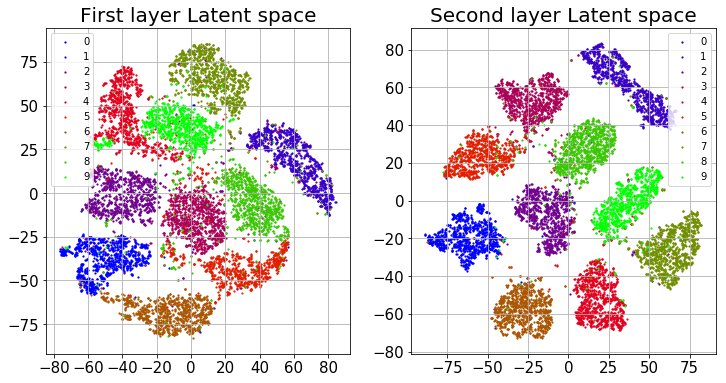

In [14]:
tsne = TSNE(n_components=2)
hidden_1_finetune = tsne.fit_transform(enc_fine_valid)
hidden_2_finetune = tsne.fit_transform(enc_2_fine_valid)

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.cla()
plt.title('First layer Latent space',fontsize = 20)
color = iter(plt.get_cmap('brg')(np.linspace(0, 1.0, num_classes)))
legend_handles = []
for i, c in enumerate(included_classes):
    clr = next(color)
    h = plt.scatter(hidden_1_finetune[targets_valid==c, 0], hidden_1_finetune[targets_valid==c, 1], c=clr, s=5., lw=0, marker='o', )
    legend_handles.append(h)
plt.grid('on')
plt.legend(legend_handles, classes_plot)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.subplot(1,2,2)
plt.cla()
plt.title('Second layer Latent space',fontsize = 20)
color = iter(plt.get_cmap('brg')(np.linspace(0, 1.0, num_classes)))
legend_handles = []
for i, c in enumerate(included_classes):
    clr = next(color)
    h = plt.scatter(hidden_2_finetune[targets_valid==c, 0], hidden_2_finetune[targets_valid==c, 1], c=clr, s=5., lw=0, marker='o', )
    legend_handles.append(h)
plt.grid('on')
plt.legend(legend_handles, classes_plot)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)



Normalized confusion matrix
[[  9.84863774e-01   0.00000000e+00   4.03632694e-03   0.00000000e+00
    0.00000000e+00   0.00000000e+00   6.05449041e-03   0.00000000e+00
    2.01816347e-03   3.02724521e-03]
 [  0.00000000e+00   9.87781955e-01   1.87969925e-03   1.87969925e-03
    9.39849624e-04   9.39849624e-04   9.39849624e-04   9.39849624e-04
    4.69924812e-03   0.00000000e+00]
 [  1.01010101e-03   3.03030303e-03   9.75757576e-01   5.05050505e-03
    1.01010101e-03   1.01010101e-03   5.05050505e-03   3.03030303e-03
    4.04040404e-03   1.01010101e-03]
 [  9.70873786e-04   0.00000000e+00   4.85436893e-03   9.54368932e-01
    0.00000000e+00   1.94174757e-02   0.00000000e+00   1.94174757e-03
    1.45631068e-02   3.88349515e-03]
 [  0.00000000e+00   5.08646999e-03   2.03458800e-03   0.00000000e+00
    9.65412004e-01   0.00000000e+00   6.10376399e-03   2.03458800e-03
    3.05188199e-03   1.62767040e-02]
 [  1.09289617e-03   0.00000000e+00   3.27868852e-03   1.31147541e-02
    2.18579235e-0

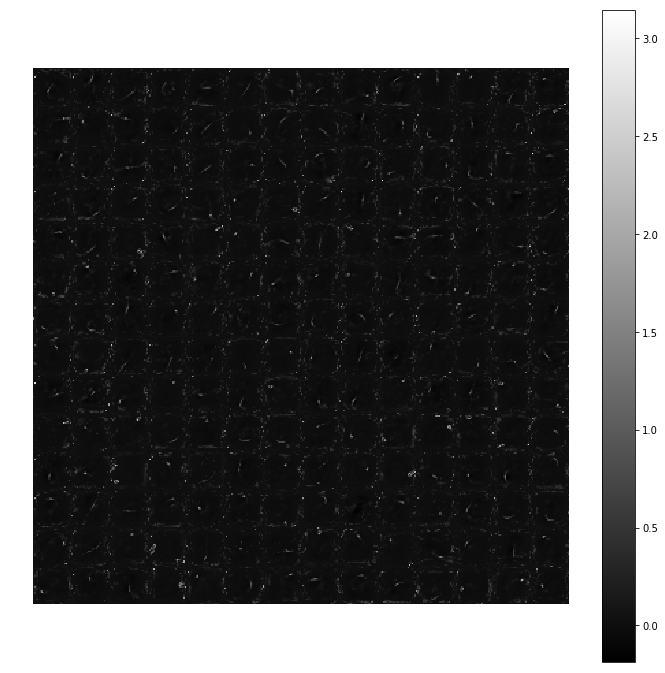

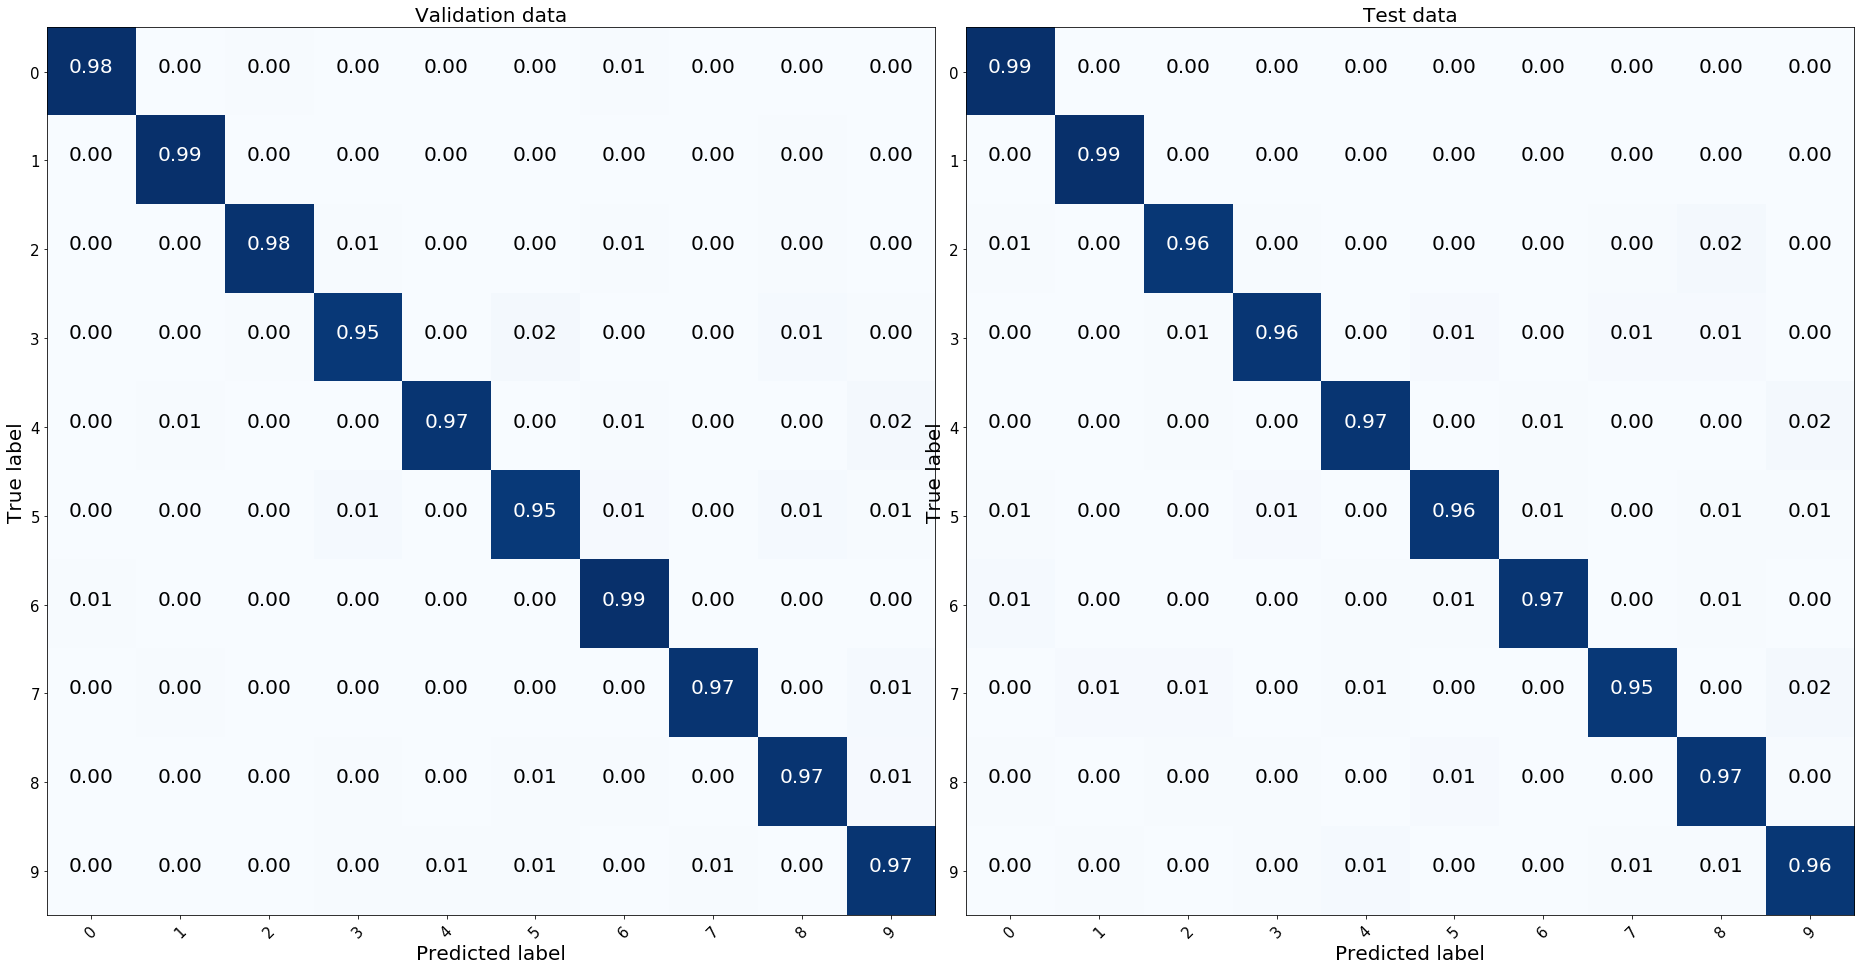

In [15]:

#%% First encoding layer
encode_weights_final = param_4[0]
encode_weights_t = encode_weights_final.transpose()
plt.figure(figsize=(12, 12))
plt.cla()
plt.axis('off')
canvas = np.zeros((28*14, 14*28))
idx = 0
for i in range(14):
    for j in range(14):
        tmp = encode_weights_t[idx]
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = (tmp).reshape(28,28)
        idx += 1
        
cax = plt.imshow(canvas,cmap = 'gray')
cbar = plt.colorbar(cax)

#%% Confusion matrices  
cnf_valid = confusion_matrix(targets_valid,preds_valid); cnf_valid = cnf_valid.astype('float') / cnf_valid.sum(axis=1)[:, np.newaxis]
cnf_test = confusion_matrix(targets_test,preds_test); cnf_test = cnf_test.astype('float') / cnf_test.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(26,20))
plt.subplot(1,2,1)
plot_confusion_matrix(cnf_valid, classes=classes_plot, normalize=True,
                      title='Validation data',include_colorbar=False)
plt.subplot(1,2,2)
plot_confusion_matrix(cnf_test, classes=classes_plot, normalize=True,
                      title='Test data',include_colorbar=False)